Step 1: Data Preprocessing

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
import torch.optim as optim


In [41]:
data_dir = r'path_to_your_dataset'

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])





In [42]:

dataset = ImageFolder(
    root=r'C:\Users\samya\Desktop\Samyaks\Assignments & Material\UB\1st sem\Intro to ML\Assignments & Homework\Assignment 2\Assignment 2\datasets\cnn_dataset\cnn_dataset',
    transform=transform
)


In [43]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Analysis

In [44]:
from collections import Counter

class_counts = Counter([label for _, label in dataset.samples])
classes = dataset.classes

print("Number of samples per class:")
for idx, class_name in enumerate(classes):
    print(f"{class_name}: {class_counts[idx]}")

def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_images = 0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images.size(0)
    mean /= total_images
    std /= total_images
    return mean, std

mean, std = calculate_mean_std(train_dataset)
print(f"Dataset Mean: {mean}")
print(f"Dataset Standard Deviation: {std}")


Number of samples per class:
0: 2800
1: 2800
2: 2800
3: 2800
4: 2800
5: 2800
6: 2800
7: 2800
8: 2800
9: 2800
A: 2800
B: 2800
C: 2800
D: 2800
E: 2800
F: 2800
G: 2800
H: 2800
I: 2800
J: 2800
K: 2800
L: 2800
M: 2800
N: 2800
O: 2800
P: 2800
Q: 2800
R: 2800
S: 2800
T: 2800
U: 2800
V: 2800
W: 2800
X: 2800
Y: 2800
Z: 2800
Dataset Mean: tensor([-0.6486, -0.6486, -0.6486])
Dataset Standard Deviation: tensor([0.6538, 0.6538, 0.6538])


Visualisation

In [47]:
def visualize_samples(train_loader, classes, mean, std):

    import torchvision
    def imshow(img, mean, std):
        img = img * std[:, None, None] + mean[:, None, None]
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    plt.figure(figsize=(10, 4))
    imshow(torchvision.utils.make_grid(images[:8], nrow=8), mean, std)
    plt.show()
    print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

Step 2: Define the CNN Architecture

In [48]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) 
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

num_classes = len(classes)
model = BasicCNN(num_classes)

summary(model, input_size=(batch_size, 3, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [32, 36]                  --
├─Sequential: 1-1                        [32, 256, 3, 3]           --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          896
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-5                       [32, 64, 14, 14]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 14, 14]          128
│    └─ReLU: 2-7                         [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-8                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-9                       [32, 128, 7, 7]           73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 7, 7]           256
│    └─ReLU: 2-11                        [32, 128, 7, 7]           --
│   

In [49]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:

            outputs = model(images)
            loss_batch = criterion(outputs, labels)

            loss += loss_batch.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = loss / len(data_loader)
    accuracy = 100 * correct / total
    return loss, accuracy


In [50]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    best_model_wts = None


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'best_model_part3.pth')
            print(f"Model saved with validation accuracy: {best_val_accuracy:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


    history = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }

    return history


In [51]:
def test_model(model, test_loader, criterion):

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted().numpy())

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy, all_labels, all_predictions


In [52]:


def calculate_metrics(all_labels, all_predictions):

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )
    return precision, recall, f1_score


In [53]:
class EarlyStopping:

    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [54]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    best_model_wts = None

    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'best_model_early_stopping.pth')
            print(f"Model saved with validation accuracy: {best_val_accuracy:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


    history = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }

    return history


In [55]:
def train_model_with_gradient_accumulation(model, train_loader, val_loader, criterion, optimizer, num_epochs, accumulation_steps):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    best_model_wts = None


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        optimizer.zero_grad()

        for i, (images, labels) in enumerate(train_loader):

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps  
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if (i + 1) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'best_model_gradient_accumulation.pth')
            print(f"Model saved with validation accuracy: {best_val_accuracy:.2f}%")

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


    history = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }

    return history


In [56]:
def k_fold_cross_validation(model_class, dataset, k_folds, num_epochs, batch_size):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = {}
    criterion = nn.CrossEntropyLoss()

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold+1}/{k_folds}')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_epoch_kfold(
                model, optimizer, criterion, train_loader
            )

            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        fold_results[fold] = {
            'model_state_dict': model.state_dict(),
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }

    return fold_results

def train_epoch_kfold(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy


In [76]:
from torchmetrics import ROC


def plot_accuracy(epochs, train_accuracies, val_accuracies, test_accuracy):
    test_accuracy_list = [test_accuracy] * len(epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.plot(epochs, test_accuracy_list, label='Test Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

def plot_loss(epochs, train_losses, val_losses, test_loss):
    test_loss_list = [test_loss] * len(epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.plot(epochs, test_loss_list, label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.show()

def plot_confusion_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(model, test_loader, classes, max_classes_to_plot=8):
    num_classes = len(classes)
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)  
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)  
    all_labels = torch.cat(all_labels)    

    plt.figure(figsize=(10, 8))

    for i in range(min(max_classes_to_plot, num_classes)):
        class_scores = all_outputs[:, i]  

        binary_labels = (all_labels == i).long()  

        roc_metric = ROC(task="binary")

        fpr, tpr, thresholds = roc_metric(class_scores, binary_labels)

        auc_value = auc(fpr, tpr)

        plt.plot(
            fpr.numpy(),
            tpr.numpy(),
            label=f'Class {classes[i]} (AUC = {auc_value:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



In [87]:
import pandas as pd

def plot_class_distribution(dataset, classes):
    class_counts = Counter([label for _, label in dataset.samples])
    plt.figure(figsize=(10, 6))
    plt.bar(classes, [class_counts[idx] for idx in range(len(classes))])
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

def plot_loss_vs_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.scatter(history['train_losses'], history['train_accuracies'], label="Training")
    plt.scatter(history['val_losses'], history['val_accuracies'], label="Validation", marker="x")
    plt.xlabel("Loss")
    plt.ylabel("Accuracy")
    plt.title("Loss vs. Accuracy Scatter Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prediction_correlation_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(14, 12))  
    sns.heatmap(cm_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
    plt.title("Correlation Matrix of Predictions")
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [59]:
mean, std = calculate_mean_std(train_dataset)
print(f"Dataset Mean: {mean}")
print(f"Dataset Standard Deviation: {std}")

model = BasicCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5 
history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)



Dataset Mean: tensor([-0.6486, -0.6486, -0.6486])
Dataset Standard Deviation: tensor([0.6538, 0.6538, 0.6538])
Model saved with validation accuracy: 89.61%
Epoch [1/5], Train Loss: 0.4378, Train Acc: 84.80%, Val Loss: 0.2773, Val Acc: 89.61%
Model saved with validation accuracy: 89.84%
Epoch [2/5], Train Loss: 0.2763, Train Acc: 89.57%, Val Loss: 0.2543, Val Acc: 89.84%
Model saved with validation accuracy: 91.46%
Epoch [3/5], Train Loss: 0.2460, Train Acc: 90.57%, Val Loss: 0.2293, Val Acc: 91.46%
Model saved with validation accuracy: 91.57%
Epoch [4/5], Train Loss: 0.2261, Train Acc: 91.15%, Val Loss: 0.2254, Val Acc: 91.57%
Model saved with validation accuracy: 91.80%
Epoch [5/5], Train Loss: 0.2108, Train Acc: 91.69%, Val Loss: 0.2167, Val Acc: 91.80%


In [62]:
model_es = BasicCNN(num_classes)
optimizer = optim.Adam(model_es.parameters(), lr=0.001)

history_early_stopping = train_model_with_early_stopping(
    model_es, train_loader, test_loader, criterion, optimizer, num_epochs, patience=3
)


Model saved with validation accuracy: 90.49%
Epoch [1/5], Train Loss: 0.4382, Train Acc: 84.82%, Val Loss: 0.2529, Val Acc: 90.49%
Model saved with validation accuracy: 90.66%
Epoch [2/5], Train Loss: 0.2760, Train Acc: 89.46%, Val Loss: 0.2412, Val Acc: 90.66%
Model saved with validation accuracy: 91.07%
Epoch [3/5], Train Loss: 0.2457, Train Acc: 90.51%, Val Loss: 0.2320, Val Acc: 91.07%
Model saved with validation accuracy: 91.61%
Epoch [4/5], Train Loss: 0.2241, Train Acc: 91.13%, Val Loss: 0.2153, Val Acc: 91.61%
Epoch [5/5], Train Loss: 0.2099, Train Acc: 91.69%, Val Loss: 0.2236, Val Acc: 91.54%


In [65]:
model_ga = BasicCNN(num_classes)
optimizer = optim.Adam(model_ga.parameters(), lr=0.001)

accumulation_steps = 4  

history_gradient_accumulation = train_model_with_gradient_accumulation(
    model_ga, train_loader, test_loader, criterion, optimizer, num_epochs, accumulation_steps
)


Model saved with validation accuracy: 90.38%
Epoch [1/5], Train Loss: 0.4781, Train Acc: 84.00%, Val Loss: 0.2601, Val Acc: 90.38%
Model saved with validation accuracy: 90.85%
Epoch [2/5], Train Loss: 0.2688, Train Acc: 89.90%, Val Loss: 0.2440, Val Acc: 90.85%
Model saved with validation accuracy: 91.40%
Epoch [3/5], Train Loss: 0.2378, Train Acc: 90.91%, Val Loss: 0.2263, Val Acc: 91.40%
Epoch [4/5], Train Loss: 0.2230, Train Acc: 91.31%, Val Loss: 0.2278, Val Acc: 90.73%
Epoch [5/5], Train Loss: 0.2066, Train Acc: 91.85%, Val Loss: 0.2210, Val Acc: 91.33%


In [67]:
k_folds = 2
fold_results = k_fold_cross_validation(
    model_class=lambda: BasicCNN(num_classes),
    dataset=dataset,
    k_folds=k_folds,
    num_epochs=5,  
    batch_size=batch_size,
)

average_val_accuracy = np.mean([fold_results[fold]['val_accuracy'] for fold in fold_results])
print(f'Average Validation Accuracy across {k_folds} folds: {average_val_accuracy:.2f}%')


Fold 1/2
Epoch [1/5], Train Loss: 0.5114, Train Acc: 82.73%, Val Loss: 0.2960, Val Acc: 89.18%
Epoch [2/5], Train Loss: 0.3025, Train Acc: 88.68%, Val Loss: 0.2734, Val Acc: 89.65%
Epoch [3/5], Train Loss: 0.2668, Train Acc: 89.92%, Val Loss: 0.2516, Val Acc: 90.70%
Epoch [4/5], Train Loss: 0.2456, Train Acc: 90.51%, Val Loss: 0.2315, Val Acc: 91.30%
Epoch [5/5], Train Loss: 0.2253, Train Acc: 91.21%, Val Loss: 0.2456, Val Acc: 90.89%
Fold 2/2
Epoch [1/5], Train Loss: 0.5155, Train Acc: 82.61%, Val Loss: 0.3305, Val Acc: 87.09%
Epoch [2/5], Train Loss: 0.2947, Train Acc: 88.90%, Val Loss: 0.3409, Val Acc: 88.07%
Epoch [3/5], Train Loss: 0.2584, Train Acc: 89.92%, Val Loss: 0.2547, Val Acc: 90.23%
Epoch [4/5], Train Loss: 0.2352, Train Acc: 90.80%, Val Loss: 0.2497, Val Acc: 90.79%
Epoch [5/5], Train Loss: 0.2163, Train Acc: 91.44%, Val Loss: 0.2587, Val Acc: 90.61%
Average Validation Accuracy across 2 folds: 90.75%


The model without methods has the highest accuracy of 91.80%, so storing that

In [68]:

model.load_state_dict(torch.load('best_model_part3.pth'))

test_loss, test_accuracy, all_labels, all_predictions = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

precision, recall, f1_score = calculate_metrics(all_labels, all_predictions)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')


C:\Users\samya\AppData\Local\Temp\ipykernel_13692\3905431855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.2167, Test Accuracy: 91.80%
Precision: 0.9216, Recall: 0.9180, F1 Score: 0.9178


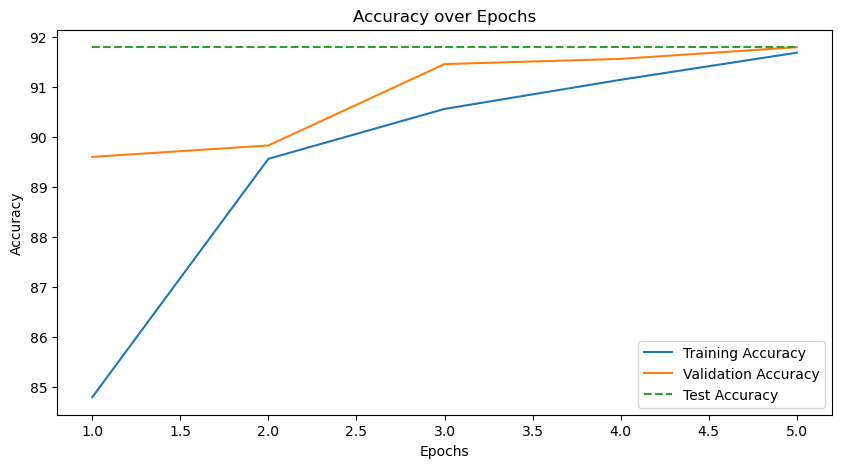

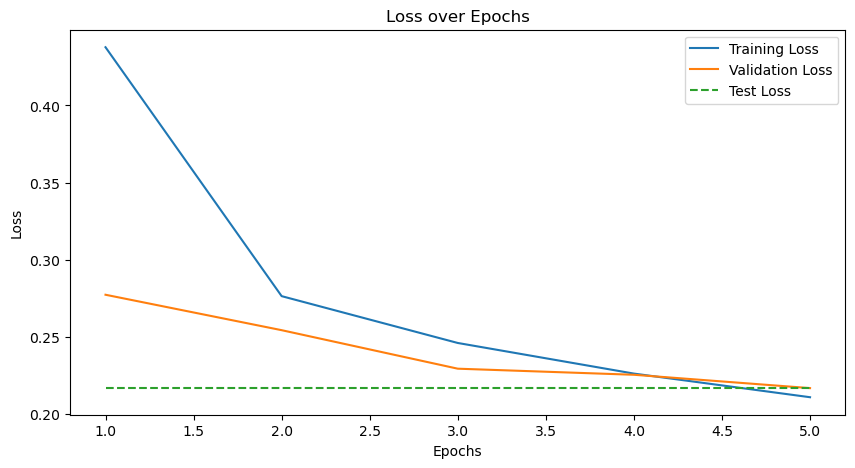

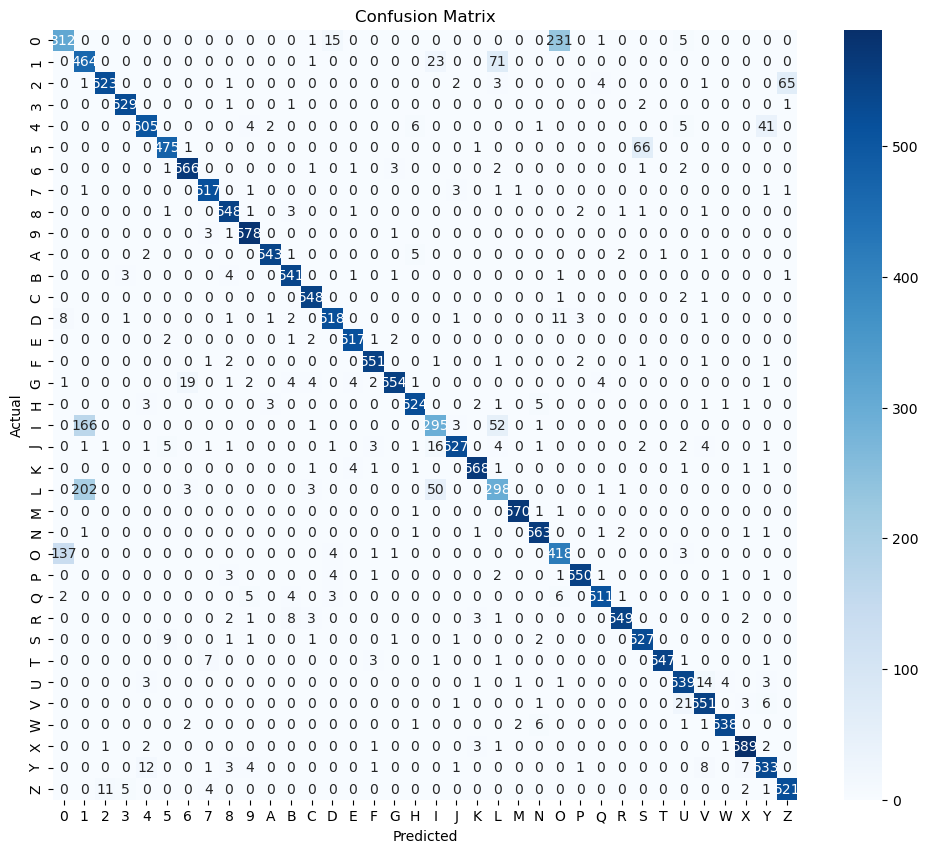

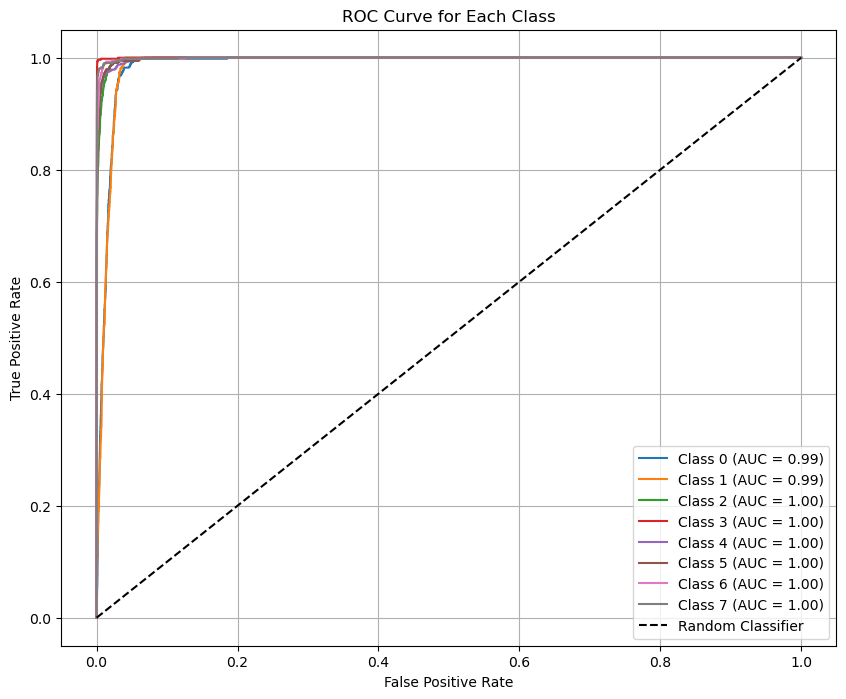

In [77]:
epochs = range(1, len(history['train_accuracies']) + 1)
plot_accuracy(epochs, history['train_accuracies'], history['val_accuracies'], test_accuracy)
plot_loss(epochs, history['train_losses'], history['val_losses'], test_loss)

plot_confusion_matrix(all_labels, all_predictions, classes)

plot_roc_curve(model, test_loader, classes)


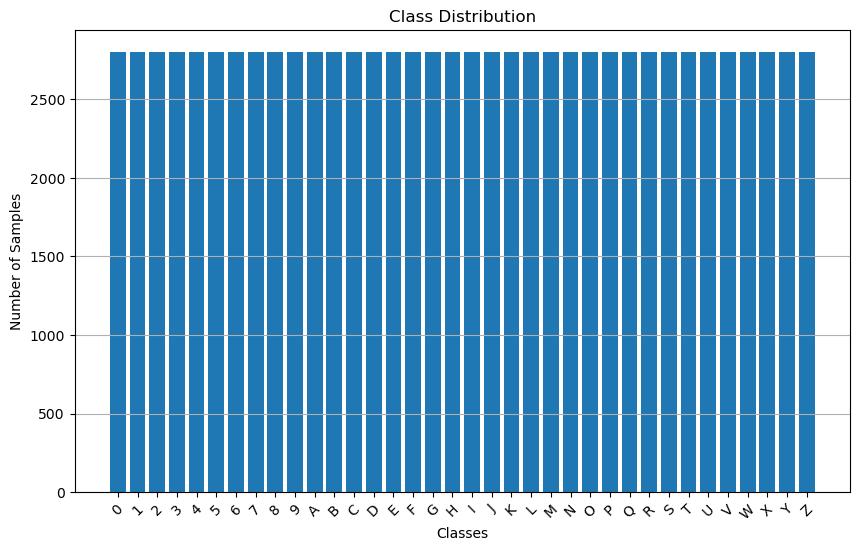

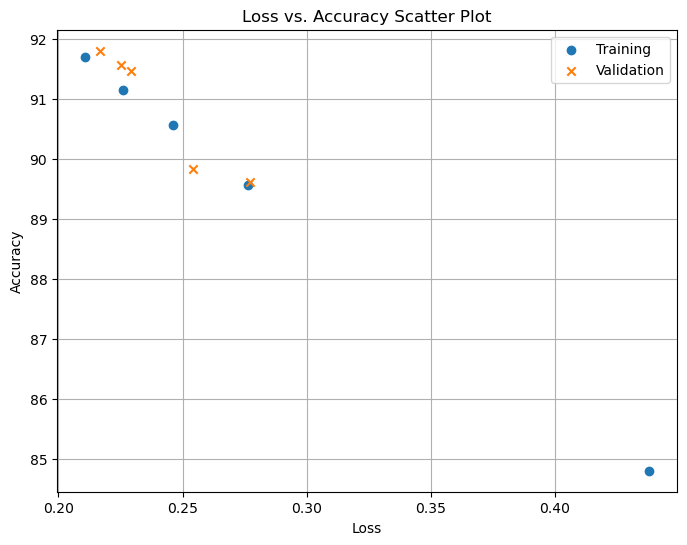

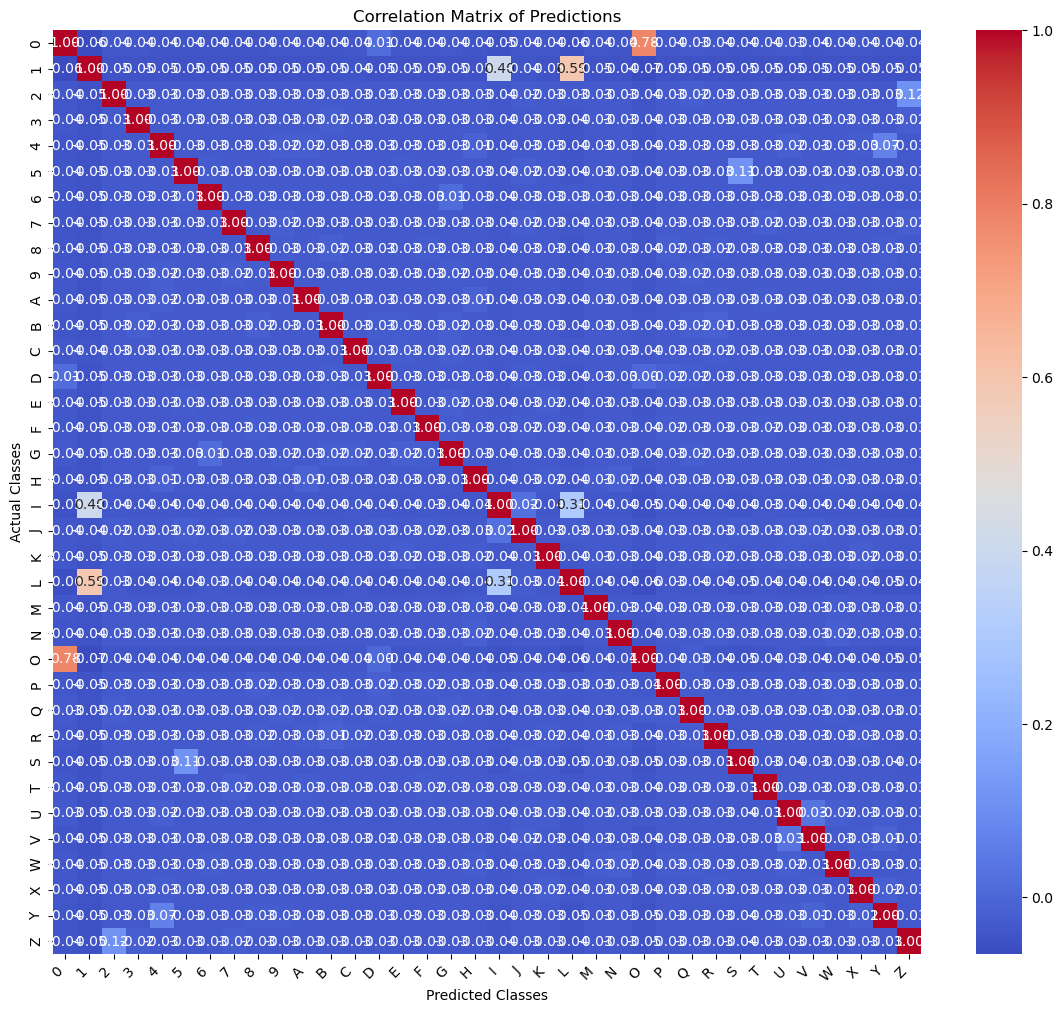

In [88]:
plot_class_distribution(dataset, classes)

plot_loss_vs_accuracy(history)

plot_prediction_correlation_matrix(all_labels, all_predictions, classes)